In [1]:
import os
import sys
from pathlib import Path
from random import choices

import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

from src.utils.imageProcessing import *
from src.utils.utils import *

# Gerar inserts - MongoDB

## Tipos de imagens

Nesta etapa, geramos os inserts para os tipos de imagens suportados no Datawarehouse. Para cada tipo de imagem cadastrado, haverá um nome, uma descrição e metadados, sendo alguns requeridos e outros opcionais.

### DICOM

In [2]:
REQUIRED_DICOM = pd.read_csv(
    '../../outputs/inserts_mongodb/required_dicom.csv')['tag']
OPTIONAL_DICOM = pd.read_csv(
    '../../outputs/inserts_mongodb/optional_dicom.csv')['tag']

REQUIRED_DICOM = REQUIRED_DICOM.to_list() + ['pathology']
OPTIONAL_DICOM = OPTIONAL_DICOM.to_list()

image_type_dicom = {
    'name': 'DICOM',
    'description': 'O formato DICOM (Digital Imaging and Communications in Medicine) é um padrão amplamente utilizado' \
                   'para imagens médicas em ambientes de assistência à saúde. Ele permite o armazenamento, transmissão e' \
                   'troca de informações médicas, incluindo imagens radiológicas, como radiografias, tomografias,' \
                   'ressonâncias magnéticas e ultrassonografias, juntamente com dados clínicos associados. O formato' \
                   'DICOM é altamente reconhecido por sua capacidade de preservar informações cruciais de pacientes e ' \
                   'de imagens médicas, garantindo a interoperabilidade entre diferentes sistemas e dispositivos de ' \
                   'imagem, e desempenha um papel fundamental no diagnóstico, tratamento e gerenciamento de pacientes' \
                   'em ambientes de saúde.',
    'requiredData': REQUIRED_DICOM,
    'optionalData': OPTIONAL_DICOM,
}

### PGM

In [3]:
REQUIRED_PGM = ['header', 'rows', 'columns', 'max_value', 'pathology']

image_type_pgm = {
    'name': 'PGM',
    'description': 'O formato PGM (Portable Gray Map) é um formato de arquivo de imagem que é usado para representar' \
                   'imagens em tons de cinza (escala de cinza). O PGM é um dos formatos simples e diretos para ' \
                   'armazenar imagens em tons de cinza e é frequentemente usado em processamento de imagens e visão' \
                   'computacional.',
    'requiredData': REQUIRED_PGM + ['pathology'],
    'optionalData': [],
}

### PNG

In [4]:
REQUIRED_PNG = ['pathology']
OPTIONAL_PNG = []

image_type_png = {
    'name': 'PNG',
    'description': 'Formato de imagem PNG',
    'requiredData': REQUIRED_PNG,
    'optionalData': OPTIONAL_PNG,
}

### JPG

In [5]:
REQUIRED_JPG = ['pathology']
OPTIONAL_JPG = []

image_type_jpg = {
    'name': 'JPG',
    'description': 'Formato de imagem JPG',
    'requiredData': REQUIRED_JPG,
    'optionalData': OPTIONAL_JPG,
}

## Bancos de imagens de Mamografia

### CBIS-DDSM

In [6]:
# Cria o objeto do banco de dados
database_CBIS_DDSM = {
    "name": "CBIS-DDSM",
            "examType": "Mamografia",
            "description": " CBIS-DDSM, ou 'Curated Breast Imaging Subset of DDSM', é um conjunto de dados de"
                           "mamografia digital, simplificado e curado, derivado do DDSM original. Com imagens em formato"
                           "DICOM e informações associadas, ele é amplamente utilizado na pesquisa de detecção de câncer"
                           "de mama, oferecendo uma coleção valiosa para desenvolver algoritmos e técnicas que aprimorem"
                           "o diagnóstico e o tratamento dessa importante condição médica.",
            "imageQuality": [],
            "imageType": "DICOM",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Mamografia/CBIS-DDSM",
}

images = []
path_metadata = "../../outputs/mamografia/extracted_metadata"

list_metadata = load_json("extracted_metadata_CBIS-DDSM", path_metadata)
list_metadata = choices(list_metadata, k=24)

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata["metadata_csv"])
    metadata_dicom = metadata["metadata_dicom_files"]["original"][0]

    database_CBIS_DDSM["imageQuality"].append(
        int(metadata_dicom["bits_stored (0028, 0101)"]))
    resized_image_path = f"D:\\mathe\\Documents\BancoDados_IC\\resized_images\\CBIS-DDSM\\image_resized_CBIS-DDSM_{i}.png"

    # Pega o path da imagem original
    directory = Path(metadata_csv["original_image_path"])
    images_paths = list(directory.rglob(f"*.dcm*"))
    images_paths = list(map(str, images_paths))
    metadata_csv["imagePath"] = images_paths[0].replace("\\", "/")
    del metadata_csv["original_image_path"]

    # Pega o path da imagem cropped
    directory = Path(metadata_csv["croppedImagePath"])
    images_paths = list(directory.rglob(f"*.dcm*"))
    images_paths = list(map(str, images_paths))
    metadata_csv["roiPath"] = images_paths[0].replace("\\", "/")
    del metadata_csv["croppedImagePath"]

    image_array = extract_image_dicom(metadata_csv["imagePath"])

    resized_image_name = resized_image_path.split("\\")[-1]
    resize_image(image_array, (255, 255), save=True, path=resized_image_path, image_type="png")

    resized_image_path = f"../assets/images/CBIS-DDSM/image_resized_CBIS-DDSM_{i}.png"

    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {'patientId': metadata_csv['patientId'], 'imagePath': metadata_csv['imagePath'],
             'roiPath': metadata_csv['roiPath'], 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_dicom[key] for key in REQUIRED_DICOM if key in metadata_dicom.keys()},
             'optionalData': {key: metadata_dicom[key] for key in OPTIONAL_DICOM if key in metadata_dicom.keys()}}

    #print(metadata_csv.keys())
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_DICOM:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_DICOM and key != 'pathology':
                image_type_dicom['optionalData'].append(key)
                image_type_dicom['optionalData'] = list(set(image_type_dicom['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_CBIS_DDSM["imageQuality"] = list(
    set(database_CBIS_DDSM["imageQuality"]))

if len(database_CBIS_DDSM["imageQuality"]) == 1:
    database_CBIS_DDSM["imageQuality"] = database_CBIS_DDSM["imageQuality"][0]

database_CBIS_DDSM["images"] = images

### CMMD

In [7]:
# Cria o objeto do banco de dados
database_CMMD = {
            "name": "CMMD",
            "examType": "Mamografia",
            "description": "O banco de dados CMMD, ou 'The Chinese Mammography Database', é uma coleção de imagens médicas" \
                           "de mamografias que é utilizada na pesquisa médica, principalmente em estudos relacionados à " \
                           "detecção precoce de câncer de mama. O CMMD contém imagens de mamografias de pacientes " \
                           "chineses e é utilizado para uma variedade de aplicações na área de saúde, incluindo o " \
                           "treinamento de sistemas de inteligência artificial para identificar possíveis anomalias e " \
                           "ajudar os médicos no diagnóstico de câncer de mama.",
            "imageQuality": [],
            "imageType": "DICOM",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Mamografia/CMMD",
}

images = []

# Carrega os metadados
list_metadata = load_json("extracted_metadata_CMMD", "../../outputs/mamografia/extracted_metadata")
list_metadata = choices(list_metadata, k=12)

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata["metadata_csv"])

    if metadata_csv['subtype'] == 'NaN':
        del metadata_csv["subtype"]
    
    n = [j for j in range(len(metadata_csv['imagePath']))] 
    for j, image_path, metadata_dicom in zip(n, metadata_csv['imagePath'], metadata["metadata_dicom_files"]):
        
        database_CMMD["imageQuality"].append(int(metadata_dicom["bits_stored (0028, 0101)"]))
        resized_image_path = f"D:\\mathe\\Documents\BancoDados_IC\\resized_images\\CMMD\\image_resized_CMMD_{i}-{j}.png"
        # resized_image_path = f"D:\\mathe\\Downloads\\images\\CMMD\\resized\\image_resized_CMMD_{i}-{j}.png"
        
        image_array = extract_image_dicom(image_path)

        resized_image_name = resized_image_path.split("\\")[-1]
        resize_image(image_array, (255, 255), save=True, path=resized_image_path, image_type="png")
    
        resized_image_path = f"../assets/images/CMMD/image_resized_CMMD_{i}-{j}.png"
        
        exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
        image = {'patientId': metadata_csv['patientId'], 'imagePath': metadata_csv['imagePath'],
                 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_dicom[key] for key in REQUIRED_DICOM if key in metadata_dicom.keys()},
             'optionalData': {key: metadata_dicom[key] for key in OPTIONAL_DICOM if key in metadata_dicom.keys()}}
        
        image['imagePath'] = image_path.replace("\\", "/")
        
        for key in metadata_csv.keys():
            if key in exclude_keys:
                continue
            elif key in REQUIRED_DICOM:
                image['requiredData'][key] = metadata_csv[key]
            else:
                if key not in OPTIONAL_DICOM and key != 'pathology':
                    image_type_dicom['optionalData'].append(key)
                    image_type_dicom['optionalData'] = list(set(image_type_dicom['optionalData']))
                image['optionalData'][key] = metadata_csv[key]
            
        images.append(image)
 
database_CMMD["imageQuality"] = list(set(database_CMMD["imageQuality"]))
    
if len(database_CMMD["imageQuality"]) == 1:
       database_CMMD["imageQuality"] = database_CMMD["imageQuality"][0]
    
database_CMMD["images"] = images

### INBREAST

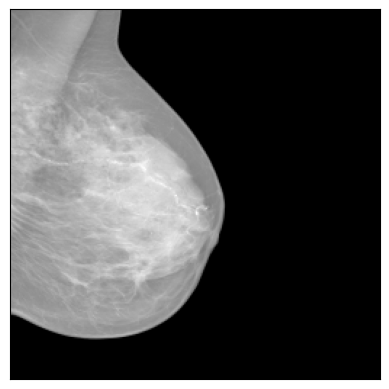

In [8]:
%matplotlib inline

database_INBREAST = {
            "name": "INBREAST",
            "examType": "Mamografia",
            "description": "O banco de dados INbreast, originário de Portugal, é uma valiosa coleção de mamografias" \
                           "digitais e sintéticas, que abrange mamografias de mama saudável e com lesões. Amplamente" \
                           "utilizado na pesquisa de câncer de mama, fornece informações clínicas detalhadas e é "\
                           "essencial para o desenvolvimento de algoritmos de diagnóstico e análise de imagens médicas.",
            "imageQuality": 14,
            "imageType": "DICOM",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Mamografia/INBREAST",
}

images = []

list_metadata = load_json("extracted_metadata_INBREAST", "../../outputs/mamografia/extracted_metadata")
list_metadata = choices(list_metadata, k=24)

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata["metadata_csv"])
    metadata_dicom = metadata["metadata_dicom_files"]
    metadata_csv["roiPath"] = metadata_csv["croppedImagePath"].replace("\\", "/")
    metadata_csv["pathology"] = "N/A"

    image_array = extract_image_dicom(metadata_csv["imagePath"])
    
    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\INBREAST\\image_resized_INBREAST_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(image_array, (255, 255), save=False)
        
    im = plt.imshow(resized_image, cmap='gray')
        
    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])
        
    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches='tight', pad_inches=0)

    resized_image_path = f"../assets/images/INBREAST/image_resized_INBREAST_{i}.png"

    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {'patientId': metadata_csv['patientId'], 'imagePath': metadata_csv['imagePath'],
             'roiPath': metadata_csv['roiPath'], 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_dicom[key] for key in REQUIRED_DICOM if key in metadata_dicom.keys()},
             'optionalData': {key: metadata_dicom[key] for key in OPTIONAL_DICOM if key in metadata_dicom.keys()}}

    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_DICOM:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_DICOM and key != 'pathology':
                image_type_dicom['optionalData'].append(key)
                image_type_dicom['optionalData'] = list(set(image_type_dicom['optionalData']))
            image['optionalData'][key] = metadata_csv[key]
            
    images.append(image)

database_INBREAST["images"] = images

### MIAS

In [9]:
database_MIAS = {
            "name": "MIAS",
            "examType": "Mamografia",
            "description": "O banco de dados MIAS (Mammographic Image Analysis Society database) é uma coleção essencial" \
                           "de mamografias digitais usada na pesquisa médica. Com imagens de mamas saudáveis e lesões " \
                           "indicativas de câncer, juntamente com informações clínicas detalhadas, ele desempenha um papel" \
                           "vital no desenvolvimento de algoritmos de detecção e diagnóstico de câncer de mama," \
                           "contribuindo para avanços no tratamento e cuidados de saúde.",
            "imageQuality": 8,
            "imageType": "PGM",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Mamografia/MIAS",
}

images = []

list_metadata = load_json("extracted_metadata_MIAS", "../../outputs/mamografia/extracted_metadata")
list_metadata = choices(list_metadata, k=24)

for i, metadata in enumerate(list_metadata):
    metadata_txt = rename_keys(metadata["metadata_txt"])
    metadata_pgm = metadata["metadata_pgm_file"]

    image_array, _ = read_pgm(metadata_txt["imagePath"])

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\MIAS\\image_resized_MIAS_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(image_array, (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/MIAS/image_resized_MIAS_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {'patientId': metadata_txt['patientId'], 'imagePath': metadata_txt['imagePath'], 
             'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_pgm[key] for key in REQUIRED_PGM if key in metadata_pgm.keys()},
             'optionalData': {}}

    if 'croppedImagePath' in metadata_txt.keys():
        metadata_txt["roiPath"] = metadata_txt["croppedImagePath"].replace("\\", "/")
        del metadata_txt['croppedImagePath']
        image['roiPath'] = metadata_txt["roiPath"]
        
    for key in metadata_txt.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_PGM:
            image['requiredData'][key] = metadata_txt[key]
        else:
            if key not in OPTIONAL_DICOM and key != 'pathology':
                image_type_pgm['optionalData'].append(key)
                image_type_pgm['optionalData'] = list(set(image_type_pgm['optionalData']))
            image['optionalData'][key] = metadata_txt[key]

    images.append(image)

database_MIAS["images"] = images

## Bancos de imagens de Ultrassom

### BUSI

In [10]:
database_BUSI = {
            "name": "BUSI",
            "examType": "Ultrassom",
            "description": "O banco de imagens de ultrassom BUSI (Breast Ultrasound Image Set) é uma coleção essencial" \
                           "de imagens de ultrassom da mama, amplamente utilizada na pesquisa médica para aprimorar a " \
                           "detecção e diagnóstico do câncer de mama. Ele fornece imagens detalhadas e variadas, " \
                           "permitindo o desenvolvimento de algoritmos avançados para análise de imagens médicas, " \
                           "contribuindo assim para avanços no campo da saúde e no combate ao câncer de mama.",
            "imageQuality": 8,
            "imageType": "PNG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Ultrassom/\Dataset_BUSI_with_GT",
}

images = []

list_metadata = pd.read_csv("../../outputs/ultrassom/BUSI_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)
    
    metadata_csv["roiPath"] = metadata_csv["croppedImagePath"].replace("\\", "/")
    del metadata_csv['croppedImagePath']

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\BUSI\\image_resized_BUSI_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/BUSI/image_resized_BUSI_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             "roiPath": metadata_csv["roiPath"], 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_PNG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_PNG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_PNG and key != 'pathology':
                image_type_png['optionalData'].append(key)
                image_type_png['optionalData'] = list(set(image_type_png['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_BUSI["images"] = images

### HMSS

In [11]:
database_HMSS = {
            "name": "HMSS",
            "examType": "Ultrassom",
            "description": "Banco de imagens de ultrassom HMSS (Hamamatsu Medical School Breast Cancer Dataset)",
            "imageQuality": 8,
            "imageType": "JPG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Ultrassom/HMSS",
}

images = []

list_metadata = pd.read_csv("../../outputs/ultrassom/HMSS_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\HMSS\\image_resized_HMSS_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/HMSS/image_resized_HMSS_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_JPG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_JPG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_JPG and key != 'pathology':
                image_type_jpg['optionalData'].append(key)
                image_type_jpg['optionalData'] = list(set(image_type_jpg['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_HMSS["images"] = images

### OASBUD

In [12]:
database_OASBUD = {
            "name": "OASBUD",
            "examType": "Ultrassom",
            "description": "Banco de imagens de ultrassom OASBUD",
            "imageQuality": 8,
            "imageType": "PNG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Ultrassom/OASBUD",
}

images = []

list_metadata = pd.read_csv("../../outputs/ultrassom/OASBUD_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)
    
    metadata_csv["roiPath"] = metadata_csv["croppedImagePath"].replace("\\", "/")
    del metadata_csv['croppedImagePath']

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\OASBUD\\image_resized_OASBUD_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/OASBUD/image_resized_OASBUD_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'roiPath': metadata_csv['roiPath'], 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_PNG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_PNG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_PNG and key != 'pathology':
                image_type_png['optionalData'].append(key)
                image_type_png['optionalData'] = list(set(image_type_png['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_OASBUD["images"] = images

### THAMMASAT

In [13]:
database_THAMMASAT = {
            "name": "THAMMASAT",
            "examType": "Ultrassom",
            "description": "Banco de imagens de ultrassom THAMMASAT",
            "imageQuality": 8,
            "imageType": "JPG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Ultrassom/Thammasat",
}

images = []

list_metadata = pd.read_csv("../../outputs/ultrassom/THAMMASAT_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\THAMMASAT\\image_resized_THAMMASAT_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/THAMMASAT/image_resized_THAMMASAT_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_JPG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_JPG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_JPG and key != 'pathology':
                image_type_jpg['optionalData'].append(key)
                image_type_jpg['optionalData'] = list(set(image_type_jpg['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_THAMMASAT["images"] = images

### UBC

In [14]:
database_UBC = {
            "name": "Ultrassom Breast Classification (UBC)",
            "examType": "Ultrassom",
            "description": "Banco de imagens de ultrassom UBC",
            "imageQuality": 8,
            "imageType": "JPG, PNG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Ultrassom/ultrassom_breast_classification",
}

images = []

list_metadata = pd.read_csv("../../outputs/ultrassom/UBC_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\UBC\\image_resized_UBC_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=True, path=resized_image_path,
                                 image_type="png")

    resized_image_path = f"../assets/images/UBC/image_resized_UBC_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_JPG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_JPG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_JPG and key != 'pathology':
                image_type_jpg['optionalData'].append(key)
                image_type_jpg['optionalData'] = list(set(image_type_jpg['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_UBC["images"] = images

## Banco de imagens de Termografia

### DMRI

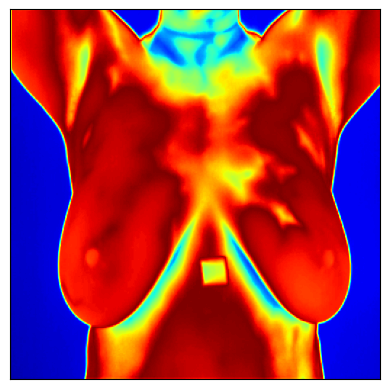

In [15]:
database_DMRI = {
            "name": "DMRI",
            "examType": "Termografia",
            "description": "Banco de imagens de termografia DMRI",
            "imageQuality": 8,
            "imageType": "PNG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Termografia/DMRI_processado",
}

images = []

list_metadata = pd.read_csv("../../outputs/termografia/DMRI_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata[:1]):
    metadata_csv = rename_keys(metadata)
    
    metadata_csv["roiPath"] = metadata_csv["croppedImagePath"].replace("\\", "/")
    del metadata_csv['croppedImagePath']

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\DMRI\\image_resized_DMRI_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=False)
        
    im = plt.imshow(resized_image, cmap='jet')
        
    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])
        
    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches='tight', pad_inches=0)
    resized_image_path = f"../assets/images/DMRI/image_resized_DMRI_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'roiPath': metadata_csv['roiPath'], 'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_PNG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_PNG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_PNG and key != 'pathology':
                image_type_png['optionalData'].append(key)
                image_type_png['optionalData'] = list(set(image_type_png['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_DMRI["images"] = images

### MammoTherm

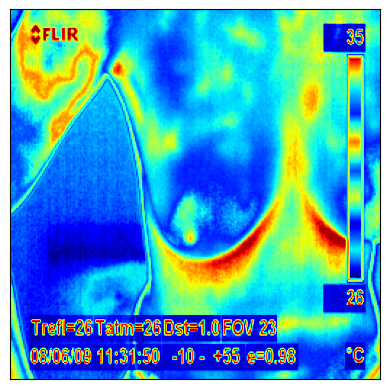

In [16]:
database_MAMMOTHERM = {
            "name": "MAMMOTHERM",
            "examType": "Termografia",
            "description": "Banco de imagens de termografia MAMMOTHERM",
            "imageQuality": 8,
            "imageType": "JPG",
            "sourceLink": "D:/mathe/Documents/BancoDados_IC/Termografia/MammoTherm",
}

images = []

list_metadata = pd.read_csv("../../outputs/termografia/MAMMOTHERM_metadata.csv")
list_metadata = list_metadata.sample(n=24)
list_metadata = [list_metadata.iloc[i:, ::].to_dict(orient='records') for i in range(list_metadata.shape[0])][0]

for i, metadata in enumerate(list_metadata):
    metadata_csv = rename_keys(metadata)

    resized_image_path = f"D:\\mathe\\Documents\\BancoDados_IC\\resized_images\\MAMMOTHERM\\image_resized_MAMMOTHERM_{i}.png"
    resized_image_name = resized_image_path.split("\\")[-1]
    
    resized_image = resize_image(metadata_csv['imagePath'], (255, 255), save=False)
        
    im = plt.imshow(resized_image, cmap='jet')
        
    # Remover os rótulos dos eixos x e y
    plt.xticks([])
    plt.yticks([])
        
    # Salva a imagem original
    plt.savefig(resized_image_path, bbox_inches='tight', pad_inches=0)

    resized_image_path = f"../assets/images/MAMMOTHERM/image_resized_MAMMOTHERM_{i}.png"
    
    exclude_keys = ['patientId', 'imagePath', 'roiPath', 'resizedImagePath']
    image = {"patientId": metadata_csv["patientId"], "imagePath": metadata_csv["imagePath"],
             'resizedImagePath': resized_image_path,
             'requiredData': {key: metadata_csv[key] for key in REQUIRED_JPG},
             'optionalData': {}}
    
    for key in metadata_csv.keys():
        if key in exclude_keys:
            continue
        elif key in REQUIRED_JPG:
            image['requiredData'][key] = metadata_csv[key]
        else:
            if key not in OPTIONAL_JPG and key != 'pathology':
                image_type_jpg['optionalData'].append(key)
                image_type_jpg['optionalData'] = list(set(image_type_jpg['optionalData']))
            image['optionalData'][key] = metadata_csv[key]

    images.append(image)

database_MAMMOTHERM["images"] = images

## Salvar no banco de dados

In [17]:
def get_db(database_name, host: str = "localhost", port: int = 27017):
    """Connecto to mongodb"""
    try:
        connection = MongoClient(host, port)
        return connection[database_name]
    except ConnectionFailure:
        sys.stderr.write("Could not connect to MongoDB")
        sys.exit(1)

image_types = [image_type_dicom, image_type_pgm, image_type_png, image_type_jpg]
databases = [database_CBIS_DDSM, database_CMMD, database_INBREAST, database_MIAS,
             database_BUSI, database_HMSS, database_OASBUD, database_THAMMASAT, database_UBC,
             database_DMRI, database_MAMMOTHERM]

save_json("image_types", image_types, "../../outputs/inserts_mongodb/json_raw")
save_json("databases", databases, "../../outputs/inserts_mongodb/json_raw")

""" db = get_db('radiomica')
db.databases.insert_many(databases)

db = get_db('radiomica')
db.imagetypes.insert_many(image_types) """

" db = get_db('radiomica')\ndb.databases.insert_many(databases)\n\ndb = get_db('radiomica')\ndb.imagetypes.insert_many(image_types) "